# Skipper Noise Modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import astropy.units as u
import astropy.constants as c
from astropy.visualization import quantity_support
import pandas as pd
from scipy.integrate import simpson
from scipy.optimize import curve_fit

In [2]:
machine = 'Linux'

if machine == 'Linux':
    path = '/home/baparker/GitHub'
elif machine == 'Laptop':
    path = 'C:/Users/Brock/Documents/Git'
elif machine == 'Desktop':
    path = 'F:/Github'

In [3]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

In [149]:
@u.quantity_input(f=u.Hz, t=u.s, delay=u.s)
def transfer(f, t, delay = 0*u.s):
    '''
    t is the integration time of the signal and pedestal levels
    f is the frequency at which the ccd is clocked
    '''
    t = t / 2 + delay

    noise_density = 2 * (np.sin((np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles())))**2 / ((np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles()))
    noise_density[f>1/t] = 0
    return noise_density

@u.quantity_input(f=u.Hz, t=u.s, delay=u.s)
def transfer_skipper(f, t, n, delay = 0*u.s):
    '''
    t is the integration time of the signal and pedestal levels
    f is the frequency at which the ccd is clocked
    '''
    t = t / 2 + delay

    part1 = 4 * (np.sin((np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles())))**2 / (2 * np.pi * f * t * n).to(u.rad, equivalencies=u.dimensionless_angles())
    part2 = abs( np.sin((2*np.pi * f * t * n).value) / np.sin((2*np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles())))

    noise_density = part1 * part2
    noise_density[f>1/t] = 0
    return noise_density

@u.quantity_input(f1=u.Hz, f2=u.Hz, t=u.s, delay=u.s)
def sig_cds(ewn, t, f1, f2, delay=0*u.s):
    '''
    ewn is voltage noise density of white noise
    Function defined in poster.
    '''
    t = t / 2 + delay

    return ewn * np.sqrt(1/t + 4*f1.si*np.log(2) + 4/3 * f2**2 * np.pi**2 * t)

@u.quantity_input(f1=u.Hz, f2=u.Hz, t=u.s, delay=u.s)
def sig_skipper(n, ewn, t, f1, f2, delay=0*u.s):
    '''
    ewn is voltage noise density of white noise
    Function defined in poster.
    '''
    t = t / 2 + delay

    return ewn * np.sqrt(1/t + 4*f1*np.log(2) + 4/3 * f2**2 * np.pi**2 * t) / np.sqrt(n)

@u.quantity_input(speed=u.s, noise_freqs=u.Hz)
def total_noise(speed, noise_density, noise_freqs):
    '''Calculate total noise by convolving the noise density spectrum with the CDS transfer function.'''

    try:
        length = len(speed)
        variance = []
        for i in range(length):
            value = simpson((noise_density * transfer(noise_freqs, speed[i]))**2, noise_freqs)
            variance.append(value)

    except:
        variance = simpson((noise_density * transfer(noise_freqs, speed))**2, noise_freqs)
        
    sigma = np.sqrt(variance)
    return sigma

## Plot CDS Transfer Functions

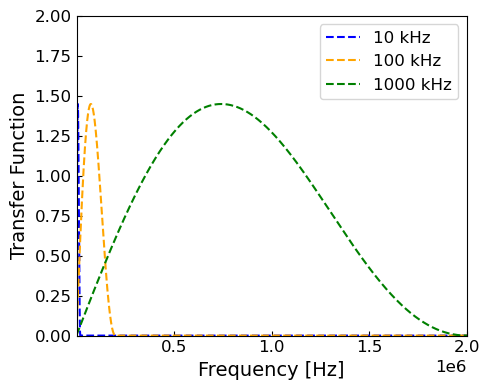

In [160]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')


freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -3, 10000) * u.s 

int_speed_10 = 1/(10*u.kHz)
int_speed_100 = 1/(100*u.kHz)
int_speed_1000 = 1/(1*u.MHz)

ax.plot(freqs, transfer(freqs, int_speed_10), label = '{:.0f}'.format((1/int_speed_10).to(u.kHz)), color = 'blue', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_100), label = '{:.0f}'.format((1/int_speed_100).to(u.kHz)), color = 'orange', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_1000), label = '{:.0f}'.format((1/int_speed_1000).to(u.kHz)), color='green', ls='--')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Transfer Function')
ax.legend(loc = 'best')
ax.set_xlim(1e3, 0.2e7)
# ax.set_xscale('log')
ax.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/cds_transfer_func.png', dpi=250)
plt.show()

## Plot Skipper Transfer Function

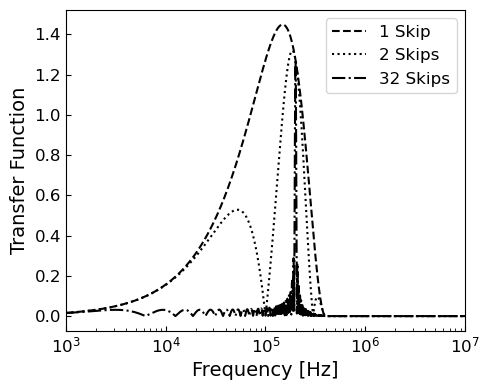

In [151]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')

freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -3, 10000) * u.s 

int_speed = 1/(2e5*u.Hz)
nskip1 = 2
nskip2 = 32

ax.plot(freqs, transfer_skipper(freqs, int_speed, 1), color = 'black', ls='--', label='1 Skip')
ax.plot(freqs, transfer_skipper(freqs, int_speed, nskip1), color = 'black', ls=':', label='2 Skips')
ax.plot(freqs, transfer_skipper(freqs, int_speed, nskip2), color = 'black', ls='dashdot', label='32 Skips')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Transfer Function')
ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
ax.set_xscale('log')
# ax.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/skipper_cds_transfer_func.png', dpi=250)
plt.show()

## Plot Total Integrated Noise vs Read Time and Skips

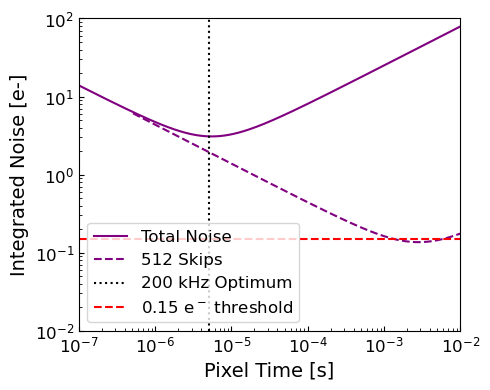

In [152]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')

freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -2, 10000) * u.s 

wn_floor = 2e-8 * u.V / ((u.Hz)**(1/2))

nc_1f = 100 * u.kHz
nc_1f2 = 100 * u.kHz#2e6 * u.Hz # Nominally 100 * u.kHz

skips = 512

conversion = 6.5e-6
# Steve recommended 5e-6
# delay = 0.01*u.us

ax.plot(tau, sig_cds(wn_floor, tau, nc_1f, nc_1f2) / conversion, label='Total Noise', color='purple')
ax.plot(tau * skips, sig_skipper(skips, wn_floor, tau, nc_1f, nc_1f2) / conversion, label='512 Skips', color='purple', ls='--')
ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
# ax.axvline(1/(5000 * u.kHz), label='5 MHz', color='k', ls=':')

ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [e-]')
ax.legend(loc = 'best')
ax.set_xlim(1e-7, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/model_integrated_noise.png', dpi=250)
plt.show()

## Plot Measured STA Noise Spectrum

In [156]:
noise_spectrum = pd.read_csv(path + '/Research/CCDs/Skipper_Noise/STANoiseSpectrum.csv', header=None)

noise_freqs = np.array(noise_spectrum[0]) * u.Hz
noise_density = np.array(noise_spectrum[1]) * u.V / (u.Hz**0.5)

opt_speed = 1/(1000*u.kHz)
cds_transfer = transfer(noise_freqs, opt_speed)

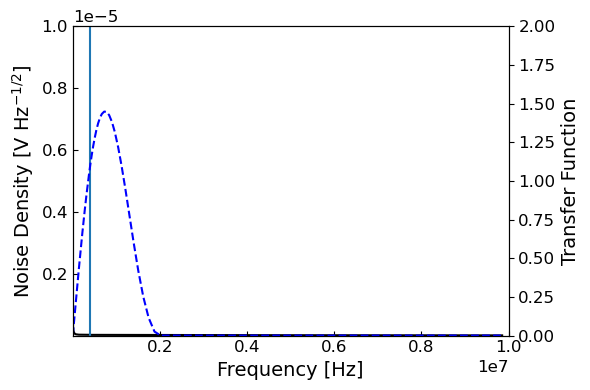

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='tight')
ax2 = ax.twinx()

ax2.plot(noise_freqs, cds_transfer, color = 'blue', ls='--')
ax.plot(noise_freqs, noise_density, color='black', ls='-')

ax.set_xlabel(r'Frequency [Hz]')
ax2.set_ylabel(r'Transfer Function')
ax.set_ylabel(r'Noise Density [V Hz$^{-1/2}$]')
# ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-5)
ax2.set_ylim(0, 2)
ax.axvline(400*u.kHz)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/sta_noise_spectrum.png', dpi=250)
plt.show()

## Plot Total Noise as a Function of Frequency

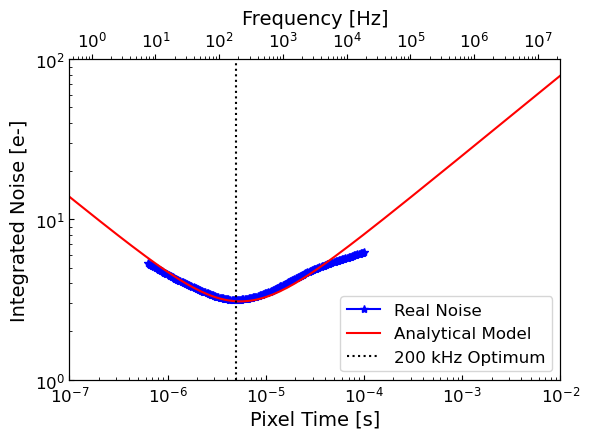

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')
ax3 = ax.twiny()

array_len = 200

taus = 1 / (np.logspace(0, 7, array_len) * u.Hz)
plot_taus = 1 / (np.logspace(4, 6.2, array_len) * u.Hz)

output_noise = total_noise(plot_taus, noise_density, noise_freqs)
ax.plot(plot_taus, output_noise / conversion, color='blue', ls='-', label='Real Noise', marker='*')
ax.plot(taus, sig_cds(wn_floor, taus, nc_1f, nc_1f2) / conversion, color='red', label='Analytical Model')

ax3.plot(1/taus, [0]*array_len, color='green', ls='-')

ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
# ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [e-]')
ax3.set_xlabel(r'Frequency [Hz]')
ax.legend(loc = 'best')
ax.set_xlim(1e-7, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax3.set_xscale('log')
ax.set_ylim(1e0, 1e2)

ax.tick_params(axis='both', direction='in', which='both')
 
fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/sta_integrated_noise.png', dpi=250)
plt.show()

## Model Noise Spectrum

after integrating the white and 1/f noise...

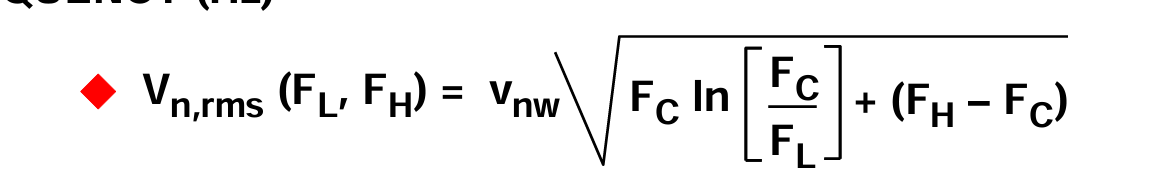

In [201]:
@u.quantity_input(f=u.Hz, f1=u.Hz, f2=u.Hz, ewn=u.V/u.Hz**0.5)
def noise_model(f, ewn, f1, f2):
    f = u.Quantity(f, u.Hz).value
    f1 = u.Quantity(f1, u.Hz).value
    f2 = u.Quantity(f2, u.Hz).value
    ewn = u.Quantity(ewn, u.V / u.Hz**0.5).value
    
    # return  n2/(f.value**2) * ewn +  n1 * ewn/(f.value) + ewn 
    # return ewn * f1.value / f.value *n1 + ewn * f2.value / f.value**2 * n2 + ewn
    # return ewn * ((f/f1)**-1 + 1) * (1 + (f/f2)**2)**-1
    return ewn * (1/(1 + (f/f2)**2) + 1/(f/f1))

In [209]:
wn_floor = 2e-8 * u.V / ((u.Hz)**(1/2))

nc_1f = 100 * u.kHz
nc_1f2 = 100 * u.kHz#2e6 * u.Hz # Nominally 100 * u.kHz

best_guess = [1.9e-8, 1e5, 0.95e7]

popt, pcov = curve_fit(noise_model, noise_freqs, noise_density, p0=best_guess, bounds=([0, 0, 0],[np.infty,np.infty,np.infty]), sigma = np.sqrt(noise_density), absolute_sigma=False)
cerr = np.sqrt(np.diag(pcov))

sig_below = noise_model(freqs, popt[0]-cerr[0],popt[1]-cerr[1],popt[2]-cerr[2])
sig_above = noise_model(freqs, popt[0]+cerr[0],popt[1]+cerr[1],popt[2]+cerr[2])

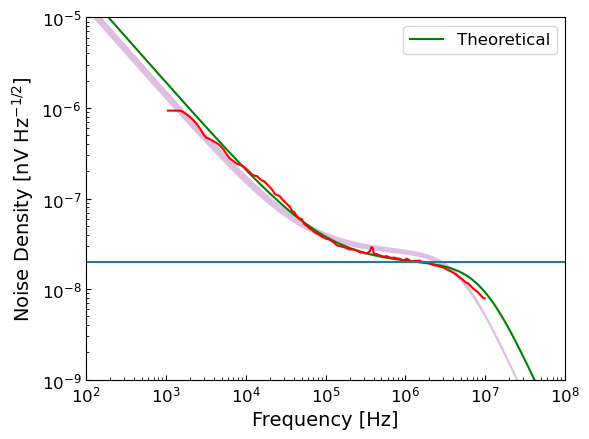

In [211]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

popt2 = [1.9e-8, 1e5, 0.95e7]

# ax.plot(freqs, noise_model(freqs, *popt), label='Total Noise \ne$_{{wn}}$={:.2e}$\pm${:.2e}\nf$_{{1nc}}$={:.2e}$\pm${:.2e}\n$f_{{2nc}}=${:.2e}$\pm${:.2e}'.format(popt[0],cerr[0],popt[1],cerr[1],popt[2],cerr[2]), color='purple')
ax.plot(freqs, noise_model(freqs, *popt2), label='Theoretical', color='green')
ax.plot(noise_freqs, noise_density, color='red', ls='-')

ax.fill_between(freqs, sig_below, sig_above, facecolor='purple', alpha=0.25)

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Noise Density [nV Hz$^{-1/2}$]')
ax.legend(loc = 'upper right')
ax.set_xlim(1e2, 1e8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-5)
ax.axhline(wn_floor)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

plt.savefig(path + '/Research/CCDs/Skipper_Noise/best_fit_noise_spectrum.png', dpi=250)
plt.show()

Use fitted function to make noise curve. Should match.

In [207]:
array_len = 50

taus = 1 / (np.logspace(0, 7, array_len) * u.Hz)
plot_taus = 1 / (np.logspace(4, 6.2, array_len) * u.Hz)
freqs = np.logspace(0,10,10000) * u.Hz

model_noise_density = noise_model(freqs, *popt2)

noise_density = noise_density

output_noise = total_noise(taus, noise_density, noise_freqs)
model_output_noise = total_noise(taus, model_noise_density, freqs)

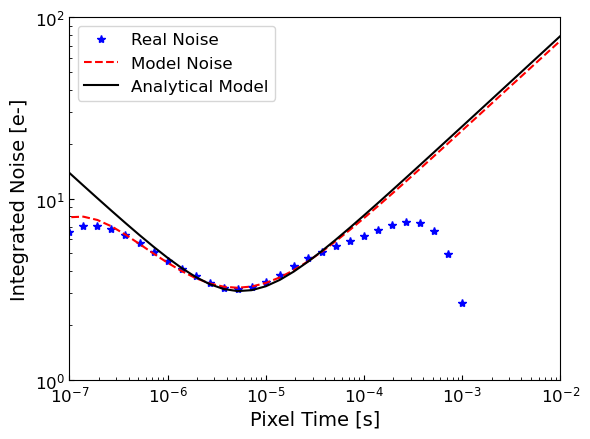

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')
# ax3 = ax.twiny()

ax.plot(taus, output_noise / conversion, color='blue', ls='', label='Real Noise', marker='*')
ax.plot(taus, model_output_noise / conversion, color='red', ls='--', label='Model Noise')
ax.plot(taus, sig_cds(wn_floor, taus, nc_1f, nc_1f2) / conversion, color='black', label='Analytical Model')

# ax3.plot(taus, [0]*array_len, color='green', ls='-')

# ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
# ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [e-]')
# ax.set_xlabel(r'Frequency [Hz]')
ax.legend(loc = 'best')
ax.set_xlim(1e-7, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
# ax3.set_xscale('log')
ax.set_ylim(1e0, 1e2)

ax.tick_params(axis='both', direction='in', which='both')
 
fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/ccd_integrated_noise_data.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/ccd_integrated_noise.png', dpi=250)
plt.show()